# import libraries

In [177]:
!pip install split-folders
!pip install torch-summary

In [427]:
import warnings
warnings.filterwarnings("ignore")
import os
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import splitfolders
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torchsummary import summary
from tqdm.auto import tqdm
import logging
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, classification_report , ConfusionMatrixDisplay
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap


# Overview dataset

In [179]:
dir="/kaggle/input/rice-image-dataset/Rice_Image_Dataset"
classes=os.listdir(dir)
classes

['Karacadag',
 'Basmati',
 'Jasmine',
 'Rice_Citation_Request.txt',
 'Arborio',
 'Ipsala']

In [180]:
classes.remove('Rice_Citation_Request.txt')
classes

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

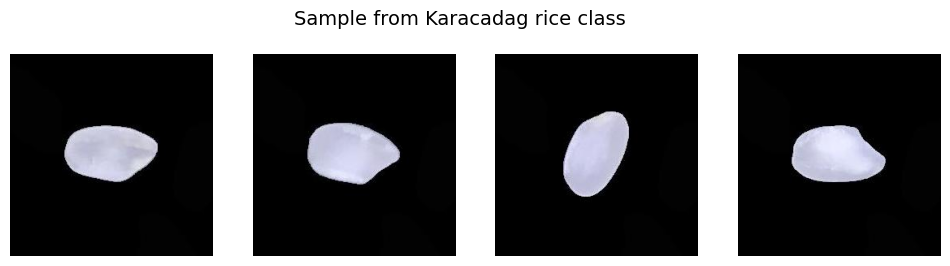

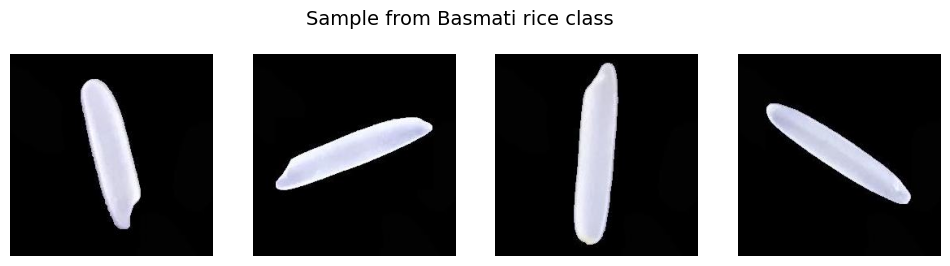

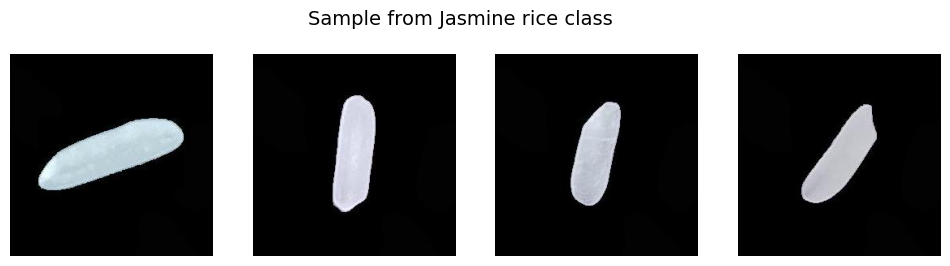

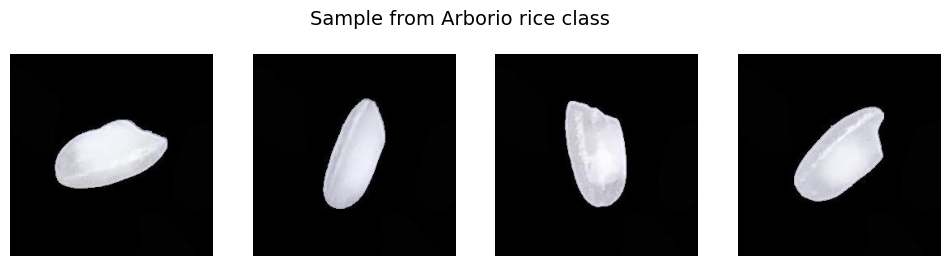

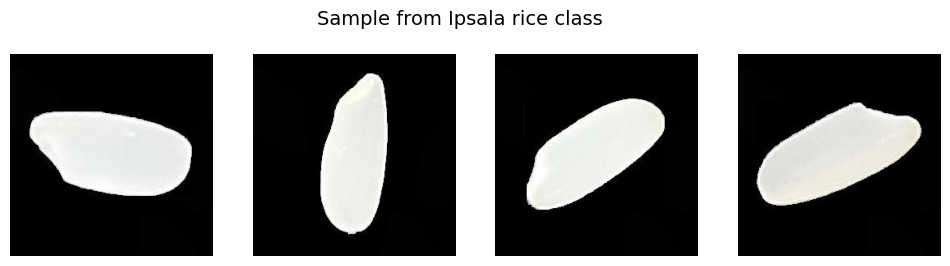

In [384]:
for rice_class in classes:
    class_dir = os.path.join(dir, rice_class)  
    images_path = os.listdir(class_dir)  
    random_images = random.sample(images_path, k=4)  

    # Plotting some sample images
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    plt.suptitle(
        f'Sample from {rice_class} rice class',
        fontsize=14,
    )  
    for i, random_image in enumerate(random_images):  
        image_path = os.path.join(class_dir, random_image) 
        image = Image.open(image_path)  

        ax[i].imshow(image) 
        ax[i].axis('off')  
    plt.show()

In [465]:
class DataVisualizer:
    def __init__(self):
        self.color_palette = {
            'primary': ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96E6B3', '#FFDD67'],
            'background': '#2F323A',
            'grid': '#3E4149',
            'text': '#FFFFFF',
            'title': '#FF6B6B'
        }
        plt.style.use('dark_background')
        
    def setup_figure(self, figsize=(12, 8)):
        fig, ax = plt.subplots(figsize=figsize)
        fig.patch.set_facecolor(self.color_palette['background'])
        ax.set_facecolor(self.color_palette['background'])
        return fig, ax
    
    def add_gradient_background(self, ax):
        gradient_colors = [(0, '#2F323A'), (1, '#1A1C20')]
        custom_cmap = LinearSegmentedColormap.from_list('custom', gradient_colors)
        
        x = np.linspace(0, 1, 2)
        y = np.linspace(0, 1, 2)
        X, Y = np.meshgrid(x, y)
        
        ax.imshow(Y, extent=[ax.get_xlim()[0], ax.get_xlim()[1], 
                            ax.get_ylim()[0], ax.get_ylim()[1]], 
                 aspect='auto', alpha=0.15, cmap=custom_cmap)
    
    def style_axis(self, ax, title, xlabel, ylabel):
        ax.set_title(title, fontsize=16, color=self.color_palette['text'], pad=20)
        ax.set_xlabel(xlabel, fontsize=14, color=self.color_palette['text'], labelpad=15)
        ax.set_ylabel(ylabel, fontsize=14, color=self.color_palette['text'], labelpad=15)
        
        ax.grid(True, linestyle='--', alpha=0.2, color=self.color_palette['grid'])
        
        for spine in ax.spines.values():
            spine.set_color(self.color_palette['grid'])
            spine.set_linewidth(2)
            
        ax.tick_params(colors=self.color_palette['text'], width=2, length=6)
visualizer = DataVisualizer()

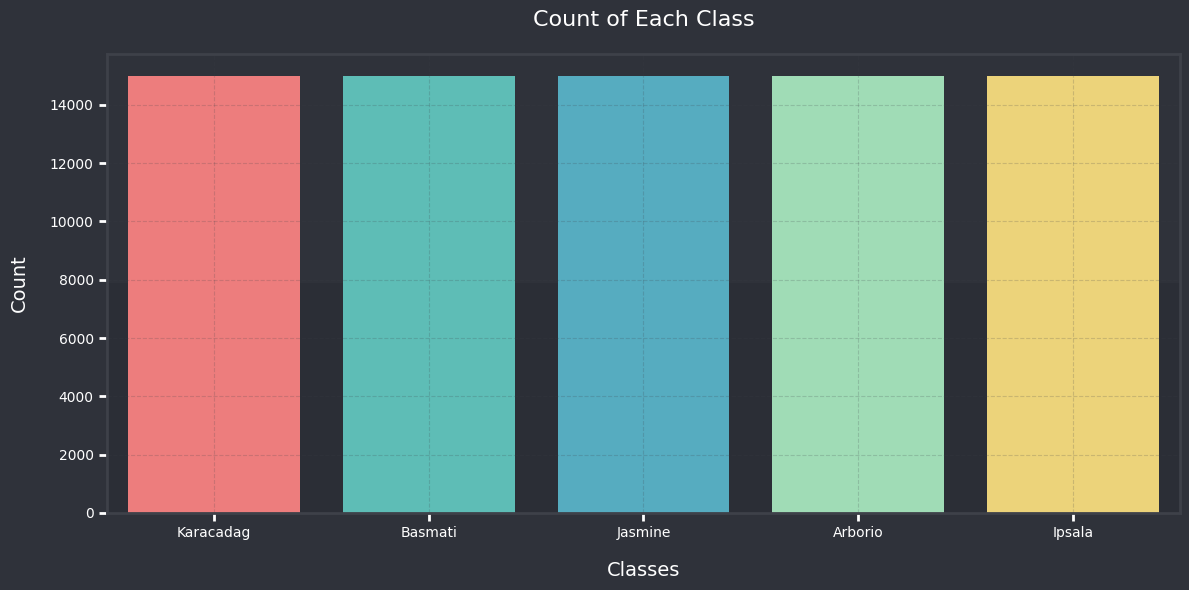

In [466]:
class_count = []  # Storing the amount of data in each class

for rice_class in classes:
    class_dir = os.path.join(dir, rice_class)
    images_path = os.listdir(class_dir)
    count = len(images_path) 
    class_count.append(count)

        # Convert data to pandas DataFrame
df = pd.DataFrame({
            'Class': classes,
            'Count': class_count
        })
        
colors = visualizer.color_palette['primary'][:len(classes)]
while len(colors) < len(classes):
    colors.extend(visualizer.color_palette['primary'][:len(classes)-len(colors)])
        
fig, ax = visualizer.setup_figure(figsize=(12, 6))
            
sns.barplot(data=df, x='Class', y='Count', palette=colors, ax=ax)
            
visualizer.style_axis(ax, "Count of Each Class", "Classes", "Count")
visualizer.add_gradient_background(ax)
            
            # Rotate x-axis labels if needed
plt.xticks(rotation=45 if len(classes) > 5 else 0)
            
plt.tight_layout()
plt.show()

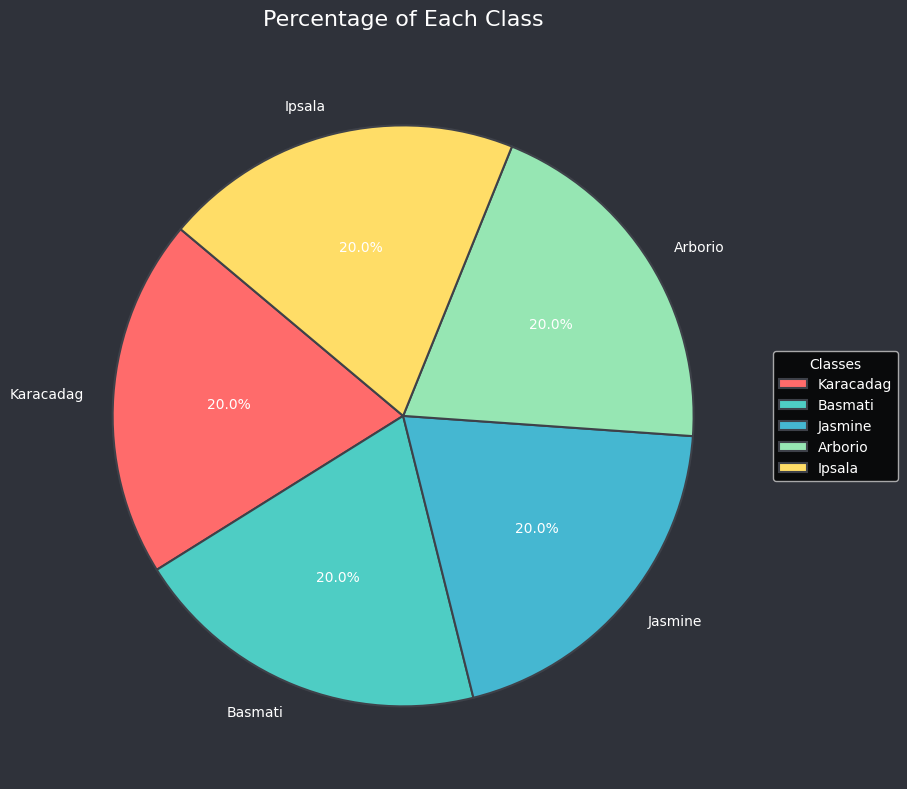

In [470]:
fig, ax = visualizer.setup_figure(figsize=(12, 8))
            
wedges, texts, autotexts = ax.pie(
                df['Count'],
                labels=df['Class'],
                autopct='%1.1f%%',
                startangle=140,
                colors=colors,
                textprops={'color': 'w', 'fontsize': 10},
                wedgeprops={"edgecolor": visualizer.color_palette['grid'], "linewidth": 1.5}
            )
ax.set_title("Percentage of Each Class", fontsize=16, 
                        color=visualizer.color_palette['text'], pad=20)
            
legend = ax.legend(wedges, df['Class'],
                             title="Classes",
                             loc="center left",
                             bbox_to_anchor=(1, 0, 0.5, 1),
                             fontsize=10)
plt.setp(legend.get_title(), color=visualizer.color_palette['text'])
            
plt.tight_layout()
plt.show()


# split data

In [184]:
splitfolders.ratio(input=dir, output='imgs', seed=42, ratio=(0.70, 0.20, 0.10))

Copying files: 75000 files [01:29, 838.39 files/s] 


In [327]:
train_path="/kaggle/working/imgs/train"
validate_path="/kaggle/working/imgs/val"
test_path="/kaggle/working/imgs/test"
train_count = sum(len(files) for _, _, files in os.walk(train_path) if files)
validate_count = sum(len(files) for _, _, files in os.walk(validate_path) if files)
test_count = sum(len(files) for _, _, files in os.walk(test_path) if files)

print(f"Total number of images in the train folder: {train_count}")
print(f"Total number of images in the validate folder: {validate_count}")
print(f"Total number of images in the test folder: {test_count}")

Total number of images in the train folder: 52500
Total number of images in the validate folder: 15000
Total number of images in the test folder: 7500


# Data preparation

In [385]:
def get_image_paths(folder_path):
    image_paths = []
    # image extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if any(filename.lower().endswith(ext) for ext in image_extensions):
                    relative_path = os.path.join(subfolder, filename)
                    image_paths.append(relative_path)    
    return image_paths

In [386]:
train_paths=get_image_paths(train_path)
validate_paths=get_image_paths(validate_path)
test_paths=get_image_paths(test_path)
len(train_paths),len(validate_paths),len(test_paths)

(52500, 15000, 7500)

In [387]:
import random
random.shuffle(train_paths)
random.shuffle(validate_paths)
random.seed(42)

## try data agumentation

In [388]:
train_transform=v2.Compose(
    [
        v2.RandomRotation(degrees=15),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.RandomResizedCrop(size=250, scale=(0.7, 1.2)),
        v2.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32,scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
    ]
    
)
val_transform=v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32,scale=True),   
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    

    ]
    
)
transform={
    "train_transform":train_transform,
    "val_transform":val_transform
}

In [395]:
original_image=Image.open(os.path.join(dir,train_paths[1000]))
transformed_image_train=Image.open(os.path.join(dir,train_paths[1000]))
transformed_image_train=train_transform(transformed_image_train)
transformed_image_val=val_transform(Image.open(os.path.join(dir,train_paths[1000])))

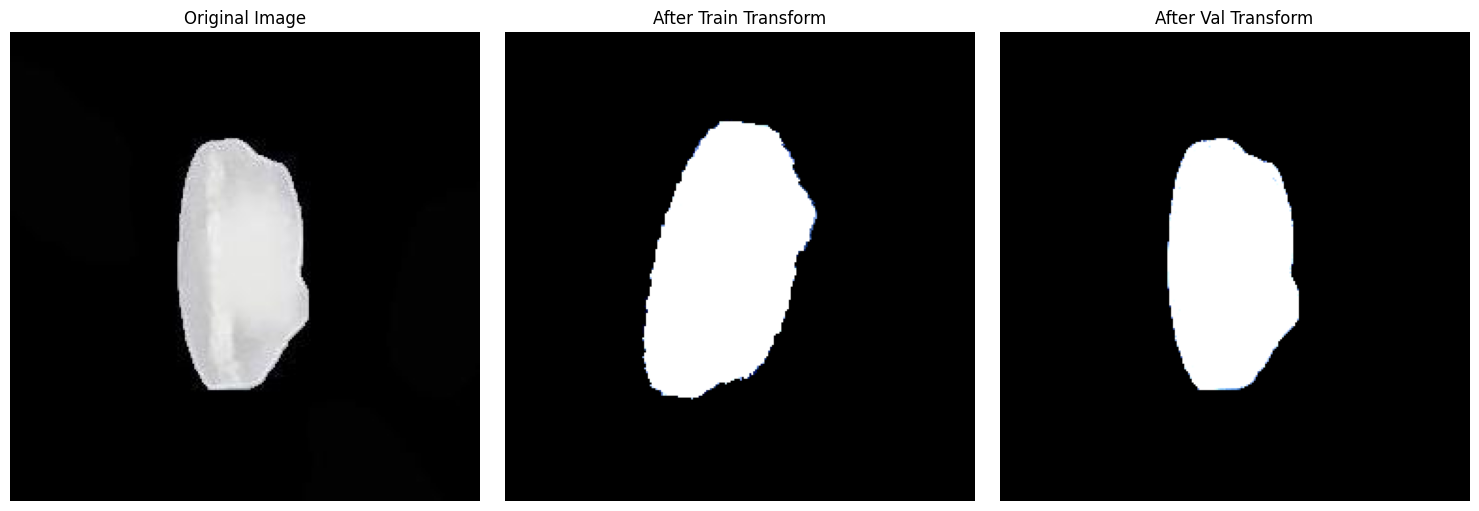

In [396]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(transformed_image_train.permute(1,2,0))
axes[1].set_title("After Train Transform")
axes[2].imshow(transformed_image_val.permute(1,2,0))
axes[2].set_title("After Val Transform")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [397]:
class CustomDataset(Dataset):
    def __init__(self, paths,transform=None,is_train=True):
        self.paths=paths
        self.transform=transform
        self.is_train=is_train
          
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,index):
        img=Image.open(os.path.join(dir,self.paths[index]))
        img=img.resize((250,250))
        label=self.paths[index].split(os.path.sep)[0]
        class_to_label = {
        'Karacadag': 0,
        'Basmati': 1,
        'Jasmine': 2,
        'Arborio': 3,
        'Ipsala': 4
        }
        numeric_label = class_to_label[label]
        if self.transform:
            if self.is_train:
                img=self.transform["train_transform"](img)
            else:
                img=self.transform["val_transform"](img)

        return img,numeric_label

In [398]:
train_data=CustomDataset(train_paths,transform)
validate_data=CustomDataset(validate_paths,transform,is_train=False)
test_data=CustomDataset(test_paths,transform,is_train=False)

4


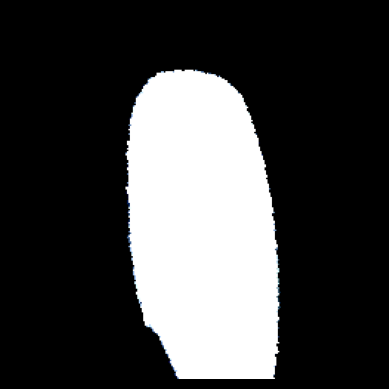

In [496]:
img=train_data[100][0]
plt.imshow(img.permute(1,2,0))
plt.grid(False)
print(train_data[100][1])
plt.axis('off')
plt.show()

In [400]:
train_loader=DataLoader(train_data,batch_size=32, shuffle=True)
validate_loader=DataLoader(validate_data,batch_size=32,shuffle=False)


In [401]:
test_loader=DataLoader(test_data,batch_size=32,shuffle=True)

# Modeling

In [402]:

class ModelArc(nn.Module):
    def __init__(self, count_class):
        super(ModelArc, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  #
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 62 * 62, 128)  
        self.fc2 = nn.Linear(128, count_class)  # Output layer

    def forward(self, X):
        out = nn.ReLU()(self.conv1(X))
        out = self.pool1(out)

        out = nn.ReLU()(self.conv2(out))
        out = self.pool2(out)

        out = out.view(-1, 32 * 62 * 62)  # Flatten the output
        out = nn.ReLU()(self.fc1(out))
        out = self.fc2(out)
        return out


In [403]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [404]:
model=ModelArc(len(classes)).to(device)
model

ModelArc(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=123008, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [405]:
#!rm -rf /kaggle/working/best_model_epoch_3.pth



In [406]:
from torchsummary import summary
summary(model, (3, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 250, 250]        448
├─MaxPool2d: 1-2                         [-1, 16, 125, 125]        --
├─Conv2d: 1-3                            [-1, 32, 125, 125]        4,640
├─MaxPool2d: 1-4                         [-1, 32, 62, 62]          --
├─Linear: 1-5                            [-1, 128]                 15,745,152
├─Linear: 1-6                            [-1, 5]                   645
Total params: 15,750,885
Trainable params: 15,750,885
Non-trainable params: 0
Total mult-adds (M): 114.75
Input size (MB): 0.72
Forward/backward pass size (MB): 11.45
Params size (MB): 60.08
Estimated Total Size (MB): 72.25


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 250, 250]        448
├─MaxPool2d: 1-2                         [-1, 16, 125, 125]        --
├─Conv2d: 1-3                            [-1, 32, 125, 125]        4,640
├─MaxPool2d: 1-4                         [-1, 32, 62, 62]          --
├─Linear: 1-5                            [-1, 128]                 15,745,152
├─Linear: 1-6                            [-1, 5]                   645
Total params: 15,750,885
Trainable params: 15,750,885
Non-trainable params: 0
Total mult-adds (M): 114.75
Input size (MB): 0.72
Forward/backward pass size (MB): 11.45
Params size (MB): 60.08
Estimated Total Size (MB): 72.25

In [407]:
num_epochs=50
lr=0.001
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,  
    gamma=0.1     
)

In [408]:
def calculate_accuracy(outputs, labels):

    _, predicted = torch.max(outputs, 1)
    
    correct = (predicted == labels).float().sum()
    
    return (correct / len(labels)) * 100.0

In [409]:
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

In [410]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss=0
    epoch_accuracy=0
    progress_bar = tqdm(enumerate(train_loader), 
                        total=len(train_loader), 
                        desc="Training", 
                        unit='batch'
                       )
    for  i , (images,labels) in progress_bar:
        images=images.to(device)
        labels=labels.to(device)
        # forword
        y_hat=model(images)
        loss=criterion(y_hat,labels)
        epoch_loss+=loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_accuracy = calculate_accuracy(y_hat, labels)
        epoch_accuracy+=batch_accuracy
        progress_bar.set_postfix({
            'batch_loss': f'{loss.item():.4f}', 
            'batch_acc': f'{batch_accuracy:.2f}%'
        }) 
    progress_bar.close()
    avg_loss = epoch_loss / len(train_loader)
    avg_accuracy = epoch_accuracy / len(train_loader)
    return avg_loss,avg_accuracy

In [411]:
def get_val_loss(model, val_loader, criterion, device):
    epoch_loss=0
    epoch_accuracy=0
    model.eval()
    with torch.no_grad():
        progress_bar = tqdm(enumerate(val_loader),
                            total=len(val_loader),
                            desc="Validation", 
                            unit='batch'
                           )
        for  i , (images,labels) in progress_bar:
            images=images.to(device)
            labels=labels.to(device)
            # forword
            y_hat=model(images)
            loss=criterion(y_hat,labels)
            batch_accuracy = calculate_accuracy(y_hat, labels)
            epoch_loss+=loss.item()
            epoch_accuracy+=batch_accuracy
            progress_bar.set_postfix({
            'val_loss': f'{loss.item():.4f}', 
            'val_acc': f'{batch_accuracy:.2f}%'
            }) 
        progress_bar.close()
    avg_loss=epoch_loss/ len(validate_loader)    
    avg_accuracy = epoch_accuracy / len(validate_loader)
    return avg_loss,avg_accuracy

In [412]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=20, device=torch.device('cuda'), patience=3,scheduler=None):
    """
    Train the model with early stopping and comprehensive tracking.
    
    Args:
        model (nn.Module): Neural network model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        criterion (nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimization algorithm
        num_epochs (int, optional): Maximum number of epochs. Defaults to 50.
        device (torch.device, optional): Computing device. Defaults to cuda.
        patience (int, optional): Early stopping patience. Defaults to 3.
        scheduler: scheduler of learning rate
    
    Returns:
        dict: Training results including losses and best model info
    """
    # Comprehensive results tracking
    results = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'best_models': [],
        'epochs_completed': 0,
        'learning_rates': []
    }
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    logging.info(f"Starting training on {device}")
    
    for epoch in range(1, num_epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch}/{num_epochs}")
        train_loss,train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        results['train_losses'].append(train_loss)
        results['train_accuracies'].append(train_accuracy) 
        
        val_loss, val_accuracy = get_val_loss(model, val_loader, criterion, device)
        results['val_losses'].append(val_loss)
        results['val_accuracies'].append(val_accuracy)
        results['learning_rates'].append(current_lr)


        
        # Comprehensive epoch reporting
        print("\n" + "="*50)
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

        if scheduler is not None:
            # For ReduceLROnPlateau
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            # For other schedulers (StepLR, CosineAnnealingLR, etc.)
            else:
                scheduler.step()
        
        # Model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            
            # Save best model
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy
            }
            torch.save(checkpoint, f'best_model_epoch_{epoch}.pth')
            
            results['best_models'].append({
                'epoch': epoch,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'learning_rate': current_lr
                
            })
            
            print(f"Model improved! Saved checkpoint at epoch {epoch}")
        else:
            early_stop_counter += 1
            print(f"No improvement for {early_stop_counter} epochs")
        
        # Update epochs completed
        results['epochs_completed'] = epoch
        
        # Early stopping
        if early_stop_counter >= patience:
            logging.info(f"Early stopping triggered after {epoch} epochs")
            break
    return results

In [413]:
results = train_model(
    model, 
    train_loader, 
    validate_loader, 
    criterion, 
    optimizer,
    num_epochs,
    device, 
    3,                    
    scheduler              
)


Epoch 1/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 1/50
Learning Rate: 0.001000
Train Loss: 0.3395 | Train Accuracy: 88.53%
Validation Loss: 0.0999 | Validation Accuracy: 96.56%
Model improved! Saved checkpoint at epoch 1

Epoch 2/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 2/50
Learning Rate: 0.001000
Train Loss: 0.1150 | Train Accuracy: 95.97%
Validation Loss: 0.0349 | Validation Accuracy: 98.83%
Model improved! Saved checkpoint at epoch 2

Epoch 3/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 3/50
Learning Rate: 0.001000
Train Loss: 0.0887 | Train Accuracy: 97.01%
Validation Loss: 0.0816 | Validation Accuracy: 96.97%
No improvement for 1 epochs

Epoch 4/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 4/50
Learning Rate: 0.001000
Train Loss: 0.0721 | Train Accuracy: 97.60%
Validation Loss: 0.0223 | Validation Accuracy: 99.21%
Model improved! Saved checkpoint at epoch 4

Epoch 5/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 5/50
Learning Rate: 0.001000
Train Loss: 0.0751 | Train Accuracy: 97.47%
Validation Loss: 0.0326 | Validation Accuracy: 99.02%
No improvement for 1 epochs

Epoch 6/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 6/50
Learning Rate: 0.000100
Train Loss: 0.0372 | Train Accuracy: 98.78%
Validation Loss: 0.0243 | Validation Accuracy: 99.21%
No improvement for 2 epochs

Epoch 7/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 7/50
Learning Rate: 0.000100
Train Loss: 0.0309 | Train Accuracy: 98.97%
Validation Loss: 0.0192 | Validation Accuracy: 99.39%
Model improved! Saved checkpoint at epoch 7

Epoch 8/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 8/50
Learning Rate: 0.000100
Train Loss: 0.0269 | Train Accuracy: 99.10%
Validation Loss: 0.0163 | Validation Accuracy: 99.45%
Model improved! Saved checkpoint at epoch 8

Epoch 9/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 9/50
Learning Rate: 0.000100
Train Loss: 0.0277 | Train Accuracy: 99.10%
Validation Loss: 0.0165 | Validation Accuracy: 99.49%
No improvement for 1 epochs

Epoch 10/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 10/50
Learning Rate: 0.000100
Train Loss: 0.0247 | Train Accuracy: 99.20%
Validation Loss: 0.0131 | Validation Accuracy: 99.57%
Model improved! Saved checkpoint at epoch 10

Epoch 11/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 11/50
Learning Rate: 0.000010
Train Loss: 0.0215 | Train Accuracy: 99.25%
Validation Loss: 0.0138 | Validation Accuracy: 99.55%
No improvement for 1 epochs

Epoch 12/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 12/50
Learning Rate: 0.000010
Train Loss: 0.0197 | Train Accuracy: 99.31%
Validation Loss: 0.0135 | Validation Accuracy: 99.57%
No improvement for 2 epochs

Epoch 13/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 13/50
Learning Rate: 0.000010
Train Loss: 0.0190 | Train Accuracy: 99.34%
Validation Loss: 0.0119 | Validation Accuracy: 99.59%
Model improved! Saved checkpoint at epoch 13

Epoch 14/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 14/50
Learning Rate: 0.000010
Train Loss: 0.0205 | Train Accuracy: 99.30%
Validation Loss: 0.0119 | Validation Accuracy: 99.59%
No improvement for 1 epochs

Epoch 15/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 15/50
Learning Rate: 0.000010
Train Loss: 0.0197 | Train Accuracy: 99.31%
Validation Loss: 0.0127 | Validation Accuracy: 99.57%
No improvement for 2 epochs

Epoch 16/50


Training:   0%|          | 0/1641 [00:00<?, ?batch/s]

Validation:   0%|          | 0/469 [00:00<?, ?batch/s]


Epoch 16/50
Learning Rate: 0.000001
Train Loss: 0.0204 | Train Accuracy: 99.28%
Validation Loss: 0.0124 | Validation Accuracy: 99.58%
No improvement for 3 epochs


In [414]:
history = {
    key: [
        float(val.item()) if isinstance(val, (list, tuple)) else float(val)
        for val in value
    ]
    for key, value in results.items()
    if key not in ['best_models', 'epochs_completed']
}
model_performance = pd.DataFrame(history)
print(tabulate(model_performance, headers='keys', tablefmt='psql'))

+----+----------------+--------------+--------------------+------------------+------------------+
|    |   train_losses |   val_losses |   train_accuracies |   val_accuracies |   learning_rates |
|----+----------------+--------------+--------------------+------------------+------------------|
|  0 |      0.339522  |    0.0998769 |            88.5329 |          96.5618 |           0.001  |
|  1 |      0.115026  |    0.034929  |            95.9739 |          98.8273 |           0.001  |
|  2 |      0.0886547 |    0.0816365 |            97.0148 |          96.9661 |           0.001  |
|  3 |      0.0720915 |    0.0223499 |            97.6024 |          99.2138 |           0.001  |
|  4 |      0.0750562 |    0.0325806 |            97.4653 |          99.0205 |           0.001  |
|  5 |      0.0372031 |    0.0242764 |            98.7831 |          99.2138 |           0.0001 |
|  6 |      0.030857  |    0.0192054 |            98.9743 |          99.387  |           0.0001 |
|  7 |      0.026888

# Evulation

## model performance

In [488]:
def plot_training_metrics(model_performance, metric='accuracies'):
        """Plot training metrics (accuracy or loss)"""
        # Convert to DataFrame if not already
        if not isinstance(model_performance, pd.DataFrame):
            model_performance = pd.DataFrame(model_performance)
            
        train_col = f'train_{metric}'
        val_col = f'val_{metric}'
        
        fig, ax = visualizer.setup_figure()
        
        train_line = sns.lineplot(data=model_performance, 
                                x=model_performance.index,
                                y=train_col,
                                label='Train',
                                color=visualizer.color_palette['primary'][0],
                                linewidth=3,
                                marker='o',
                                markersize=8,
                                ax=ax)
        
        val_line = sns.lineplot(data=model_performance,
                              x=model_performance.index,
                              y=val_col,
                              label='Validation',
                              color=visualizer.color_palette['primary'][1],
                              linewidth=3,
                              marker='o',
                              markersize=8,
                              ax=ax)
        
        visualizer.style_axis(ax, 
                        f"Training vs Validation {metric.capitalize()}", 
                        "Epoch", 
                        metric.capitalize())
        visualizer.add_gradient_background(ax)
        
        legend = ax.legend(fontsize=12, 
                          facecolor=visualizer.color_palette['background'],
                          edgecolor=visualizer.color_palette['text'], 
                          framealpha=0.8,
                          loc='best')
        for text in legend.get_texts():
            text.set_color(visualizer.color_palette['text'])
            
        for line, data, color, offset in zip(
            [train_line, val_line], 
            [model_performance[train_col], model_performance[val_col]], 
            visualizer.color_palette['primary'][:2], 
            [(0, -20), (0, 20)]
        ):
            max_val = data.max()
            max_idx = data.idxmax()
        if metric=='accuracies':
            ax.annotate(f'Max: {max_val:.3f}',
                       xy=(max_idx, max_val),
                       xytext=offset,
                       textcoords='offset points',
                       color=color,
                       fontsize=10,
                       bbox=dict(facecolor=visualizer.color_palette['background'], 
                               edgecolor=color,
                               alpha=0.7,
                               boxstyle='round,pad=0.5'))
        
        plt.tight_layout()
        plt.show()

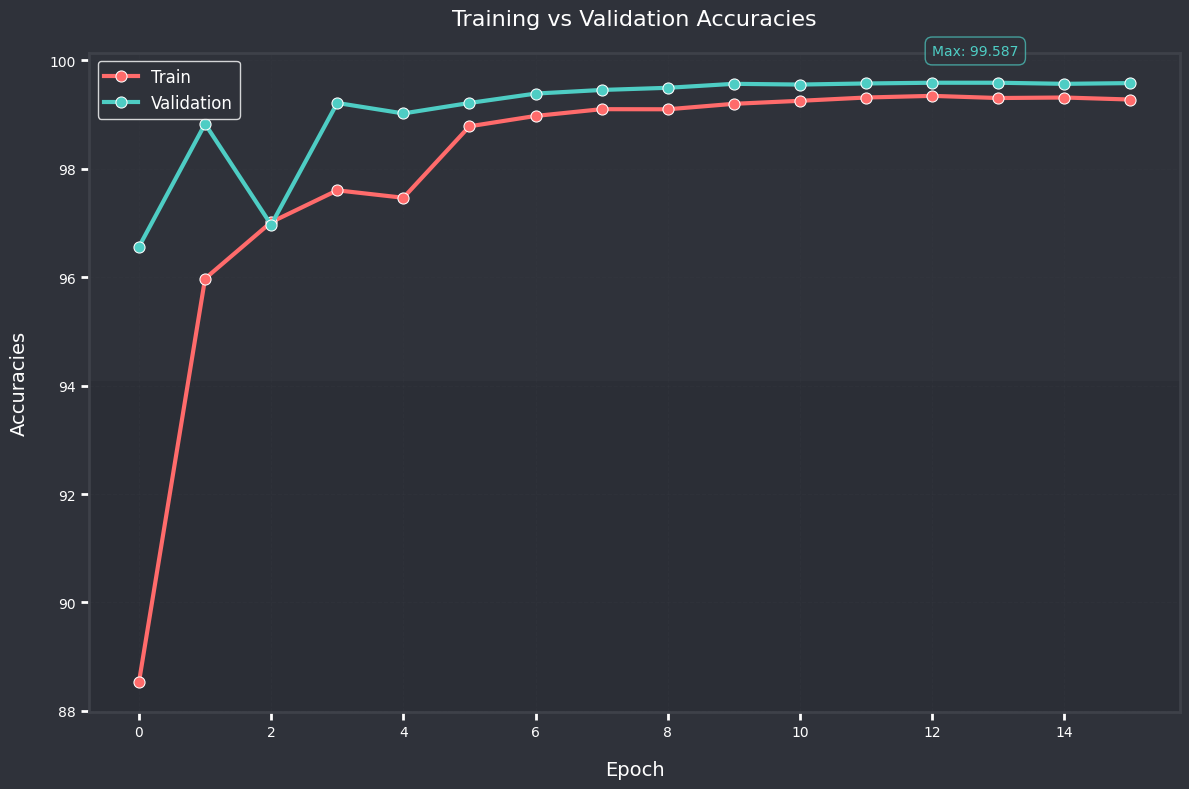

In [489]:
model_performance_df = pd.DataFrame({
    'train_accuracies':history["train_accuracies"] ,
    'val_accuracies':history["val_accuracies"] ,
    'train_losses':history["train_losses"] ,
    'val_losses':history["val_losses"] 
})
plot_training_metrics(model_performance_df, metric='accuracies')


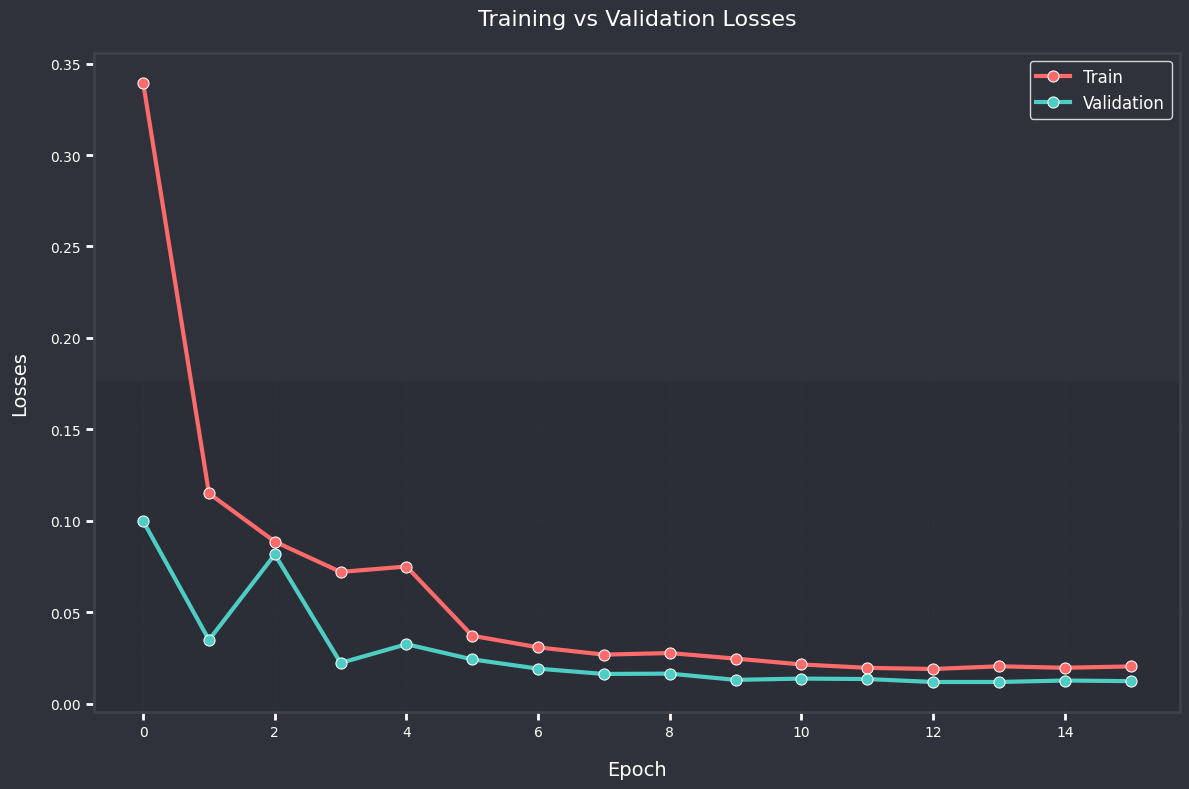

In [490]:
plot_training_metrics(model_performance_df, metric='losses')

In [417]:
def get_test_metrics(model, test_loader, criterion, device):
    epoch_loss = 0
    epoch_accuracy = 0
    model.eval()
    with torch.no_grad():
        progress_bar = tqdm(enumerate(test_loader),
                           total=len(test_loader),
                           desc="Testing",
                           unit='batch')
        for i, (images, labels) in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            # Forward
            y_hat = model(images)
            loss = criterion(y_hat, labels)
            batch_accuracy = calculate_accuracy(y_hat, labels)
            epoch_loss += loss.item()
            epoch_accuracy += batch_accuracy
            progress_bar.set_postfix({
                'test_loss': f'{loss.item():.4f}',
                'test_acc': f'{batch_accuracy:.2f}%'
            })
        progress_bar.close()
    avg_loss = epoch_loss / len(test_loader)
    avg_accuracy = epoch_accuracy / len(test_loader)
    return avg_loss, avg_accuracy

4


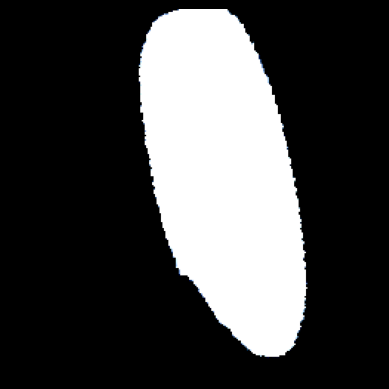

In [498]:
img=train_data[100][0]
plt.imshow(img.permute(1,2,0))
plt.grid(False)
print(train_data[100][1])
plt.axis('off')
plt.show()

In [499]:
# device_2 = torch.device("cpu")
best_model = ModelArc(len(classes)).to(device)
checkpoint = torch.load("/kaggle/working/best_model_epoch_13.pth", map_location=device)  # Apply map_location here
best_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [500]:
test_loss,test_accuracy=get_test_metrics(best_model,test_loader,criterion, device)
print("\nModel Evaluation Results on test set:")
print(f'Loss: {test_loss:.4f}')
print(f'Accuracy: {test_accuracy}%')

Testing: 100%|██████████| 235/235 [00:31<00:00,  7.54batch/s, test_loss=0.0051, test_acc=100.00%]


Model Evaluation Results on test set:
Loss: 0.0127
Accuracy: 99.64095306396484%


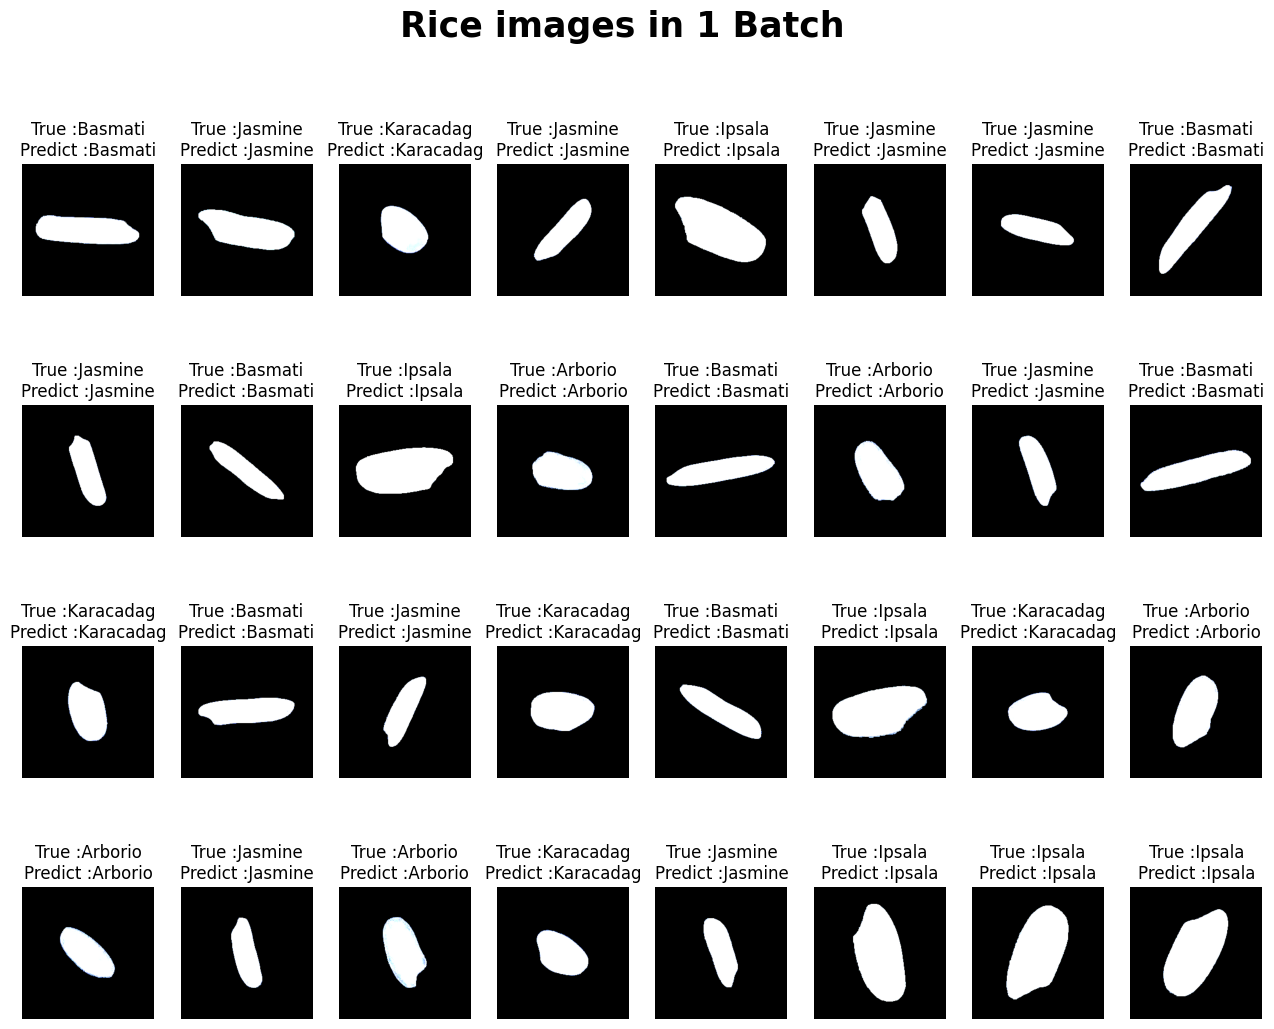

In [422]:
cpu_best_model=best_model.cpu()
for imgs, labels in test_loader :
    break
labels_map = {
        0:'Karacadag',
        1:'Basmati',
        2:'Jasmine',
        3:'Arborio',
        4:'Ipsala'
        }
# Plot 1 batch of test_loader images with True and Predicted label
plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Rice images in 1 Batch', fontsize=25, fontweight='bold')
for i in range(32) :
    ax = plt.subplot(4, 8, i+1)
    img = torch.permute(imgs[i], (1, 2, 0))
    plt.imshow(img)
    label = labels_map[int(labels[i])]
    img = img[i].unsqueeze(0)
    img = imgs[i].unsqueeze(0)
    out = cpu_best_model(img)
    predict = labels_map[int(out.argmax())]
    plt.title(f'True :{label}\nPredict :{predict}')
    plt.axis('off')

plt.show()

In [423]:
import numpy as np
y_true = []
y_pred = []
for images, labels in test_loader:
    labels = labels.numpy()
    outputs = best_model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [501]:
classes = labels_map.values()

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1500
         1.0       1.00      0.99      1.00      1500
         2.0       0.99      1.00      0.99      1500
         3.0       0.99      1.00      0.99      1500
         4.0       1.00      1.00      1.00      1500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



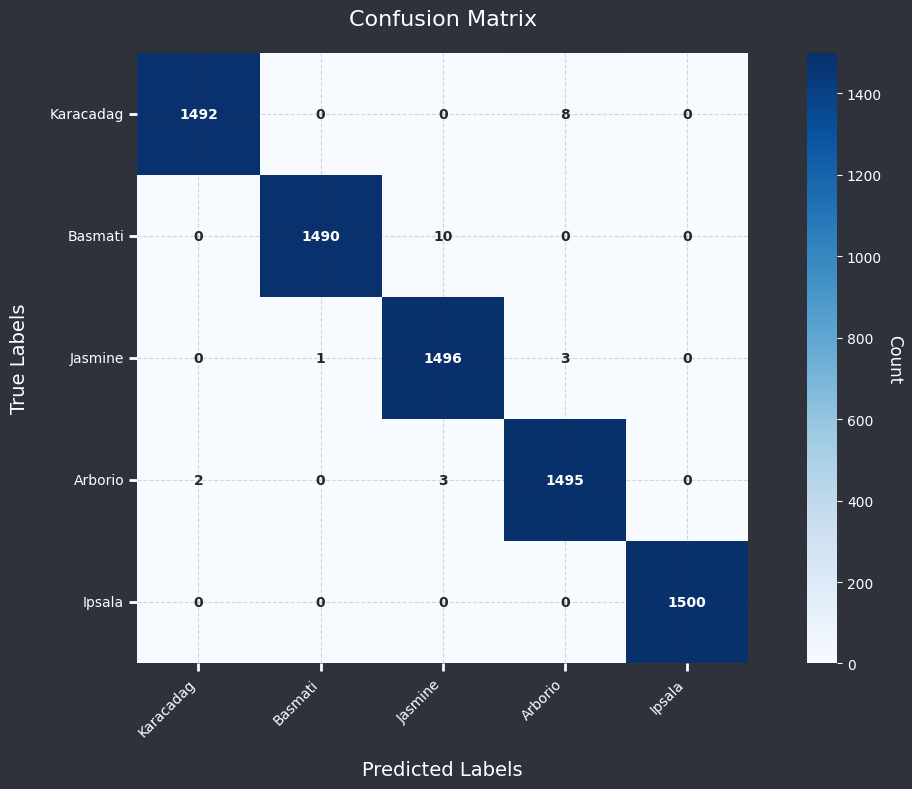

In [503]:
cm = confusion_matrix(y_true, y_pred)
        
fig, ax = visualizer.setup_figure(figsize=(12, 8))
        
        # Create heatmap
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            square=True,
            xticklabels=classes,
            yticklabels=classes,
            ax=ax,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 10, 'weight': 'bold'})
        
visualizer.style_axis(ax, 
                'Confusion Matrix', 
                'Predicted Labels', 
                'True Labels')
        
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
        
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Count', 
                    color=visualizer.color_palette['text'],
                    fontsize=12,
                    rotation=270,
                    labelpad=15)
cbar.ax.tick_params(colors=visualizer.color_palette['text'])
        
plt.tight_layout()
plt.show()

